## Gaussian Process Inference

### Regression

Let’s create some regression data, and then fit the data with a GP, implementing every step from scratch. We’ll sample data from
$$
y(x)=sin(x)+\frac{1}{2} sin(4x) + \epsilon
$$
with $\epsilon \sim N(0,\sigma^2)$. We'll start by using a noise standard deviation $\sigma=0.25$.

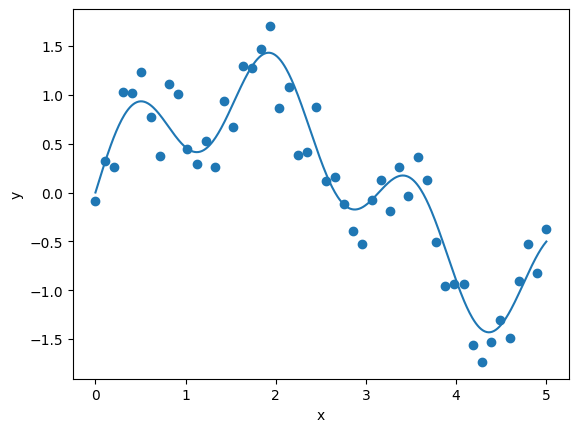

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def data_generator(x, sig):
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(x.shape[0]) * sig

sig = 0.25
train_x, test_x = np.linspace(0, 5, 50), np.linspace(0, 5, 500)
train_y, test_y = data_generator(train_x, sig), data_generator(test_x, sig=0.)

plt.scatter(train_x, train_y, label='train')
plt.plot(test_x, test_y, label='test')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now, let’s specify a GP prior over the latent noise-free function. We’ll use a mean function $m(x)=0$, and an RBF covariance function (kernel).


In [2]:
def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """
    Compute the RBF (squared exponential) kernel between two sets of points.
    
    Parameters:
    -----------
    x1: array, shape (n_samples_1, n_features) or (n_samples_1,)
        First set of input points
    x2: array, shape (n_samples_2, n_features) or (n_samples_2,)
        Second set of input points
    length_scale: float
        Length scale parameter of the kernel (controls smoothness)
    sigma_f: float
        Signal variance parameter (controls output variance)
    
    Returns:
    --------
    K: array, shape (n_samples_1, n_samples_2)
        Covariance matrix between x1 and x2
    """
    # Reshape inputs if they are 1D
    x1 = x1.reshape(-1, 1) if x1.ndim == 1 else x1
    x2 = x2.reshape(-1, 1) if x2.ndim == 1 else x2
    
    # Compute squared Euclidean distance between all pairs of points
    # Using the expanded formula: (x-y)^2 = x^2 - 2xy + y^2
    sq_norm_1 = np.sum(x1**2, axis=1).reshape(-1, 1)
    sq_norm_2 = np.sum(x2**2, axis=1).reshape(1, -1)
    sq_dist = sq_norm_1 + sq_norm_2 - 2 * np.dot(x1, x2.T)
    
    # Compute the covariance matrix
    K = sigma_f**2 * np.exp(-sq_dist / (2 * length_scale**2))
    
    return K

In [3]:
mean = np.zeros(test_x.shape[0])
cov = rbf_kernel(test_x, test_x, length_scale=0.2, sigma_f=1.0)

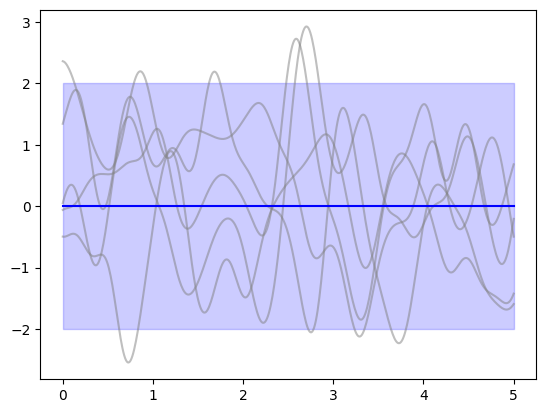

In [4]:
prior_samples = np.random.multivariate_normal(mean, cov, 5)
plt.plot(test_x, prior_samples.T, color='gray', alpha=0.5)
plt.plot(test_x, mean, color='blue', label='prior mean')
plt.fill_between(test_x, mean - 2 * np.diag(cov), mean + 2 * np.diag(cov), color='blue', alpha=0.2, label='prior 95% CI')

Perhaps our prior functions were too quickly varying. Let’s guess a length-scale of 0.4. We’ll also guess a noise standard deviation of 0.75. These are simply hyperparameter initializations — we will learn these parameters from the marginal likelihood.

In [5]:
init_length_scale = 0.4
init_std = 0.5

def negative_maginal_log_likelihood(params):
    """
    Negative marginal log-likelihood for Gaussian process regression.
    
    Parameters:
    -----------
    params: array, shape (2,)
        Array containing the kernel hyperparameters (length scale and standard deviation)
    
    Returns:
    --------
    nml: float
        Negative marginal log-likelihood
    """
    # Unpack kernel hyperparameters
    length_scale, sigma = params
    
    # Compute the kernel matrix
    K = rbf_kernel(train_x, train_x, length_scale)
    kernel_term = -0.5 * train_y @ np.linalg.inv(K + sigma**2 * np.eye(train_x.shape[0])) @ train_y
    logdet_term = -0.5 * np.log(np.linalg.det(K + sigma**2 * np.eye(train_x.shape[0])))
    constant_term = -train_x.shape[0] / 2 * np.log(2 * np.pi)
    
    # Compute the negative marginal log-likelihood
    nml = -(kernel_term + logdet_term + constant_term)
    
    return nml

In [6]:
from scipy.optimize import minimize

# Optimize the negative marginal log-likelihood
learned_params = minimize(negative_maginal_log_likelihood, x0=[init_length_scale, init_std], bounds=((0.01, 10.), (0.01, 10.)))
learned_length_scale, learned_std = learned_params.x

In [7]:
print(f'Learned length scale: {learned_length_scale:.2f}')
print(f'Learned standard deviation: {learned_std:.2f}')

Learned length scale: 0.52
Learned standard deviation: 0.27


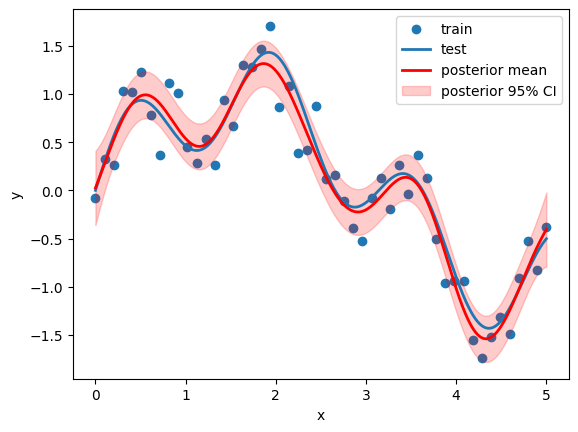

In [8]:
# Make predictions on the test data
K_train_x_test = rbf_kernel(train_x, test_x, learned_length_scale)
K_train_x_train = rbf_kernel(train_x, train_x, learned_length_scale)
K_test_x_test = rbf_kernel(test_x, test_x, learned_length_scale)

posterior_mean = K_train_x_test.T @ np.linalg.inv(K_train_x_train + learned_std**2 * np.eye(train_x.shape[0])) @ train_y
posterior_cov = K_test_x_test - K_train_x_test.T @ np.linalg.inv(K_train_x_train + learned_std**2 * np.eye(train_x.shape[0])) @ K_train_x_test

lower_bound = posterior_mean - 2 * np.sqrt(np.diag(posterior_cov))
upper_bound = posterior_mean + 2 * np.sqrt(np.diag(posterior_cov))

plt.scatter(train_x, train_y, label='train')
plt.plot(test_x, test_y, label='test', linewidth=2.)
plt.plot(test_x, posterior_mean, color='red', label='posterior mean', linewidth=2.)
plt.fill_between(test_x, lower_bound, upper_bound, color='red', alpha=0.2, label='posterior 95% CI')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Reproduce result with `GPyTorch`

In [9]:
import torch
import gpytorch

# Convert numpy arrays to PyTorch tensors
train_x_tensor = torch.from_numpy(train_x).float()
train_y_tensor = torch.from_numpy(train_y).float()
test_y_tensor = torch.from_numpy(test_y).float()

# Define the Gaussian process model with zero mean and RBF kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_tensor, train_y_tensor, likelihood)
training_iter = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x_tensor)
    loss = -mll(output, train_y_tensor)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
              f'squared lengthscale: '
              f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
              f'noise variance: {model.likelihood.noise.item():.3f}')
    optimizer.step()

Iter 1/50 - Loss: 1.004 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.976 squared lengthscale: 0.644 noise variance: 0.644
Iter 21/50 - Loss: 0.948 squared lengthscale: 0.597 noise variance: 0.598
Iter 31/50 - Loss: 0.920 squared lengthscale: 0.557 noise variance: 0.554
Iter 41/50 - Loss: 0.893 squared lengthscale: 0.530 noise variance: 0.512


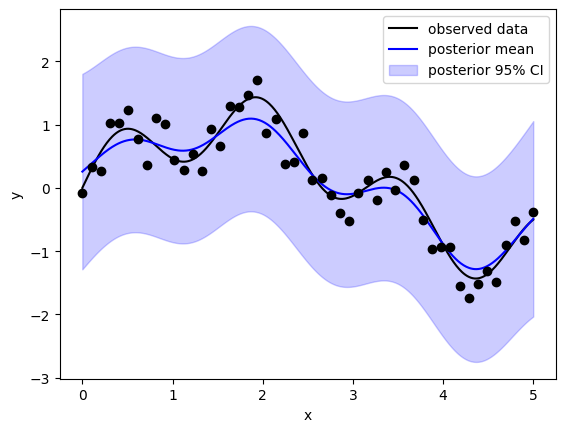

In [11]:
with torch.no_grad():
    # Get into evaluation (predictive posterior
    test_x_tensor = torch.from_numpy(test_x).float()
    model.eval()
    likelihood.eval()
    # Make predictions
    observed_pred = likelihood(model(test_x_tensor))
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
    plt.scatter(train_x, train_y, color='black', zorder=10)
    plt.plot(test_x, test_y, color='black', label='observed data')
    plt.plot(test_x, observed_pred.mean, color='blue', label='posterior mean')
    plt.fill_between(test_x, lower, upper, color='blue', alpha=0.2, label='posterior 95% CI')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()